In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt

# load functions
from functions.feature_engineering import *

In [50]:
# set some colors
spotify_green = "#1DB954"
spotify_black = "#191414"

In [8]:
# read in data
artists, tracks = get_data(
    audio_path="../../data/spotify_audio_features.json",
    artists_path="../../data/spotify_artists.json",
    playlists_path="../../data/spotify_top_50_playlists.json",
)

In [9]:
# take unique tracks for our visualizations
distinct_tracks = tracks.drop_duplicates(subset=["track_id"])

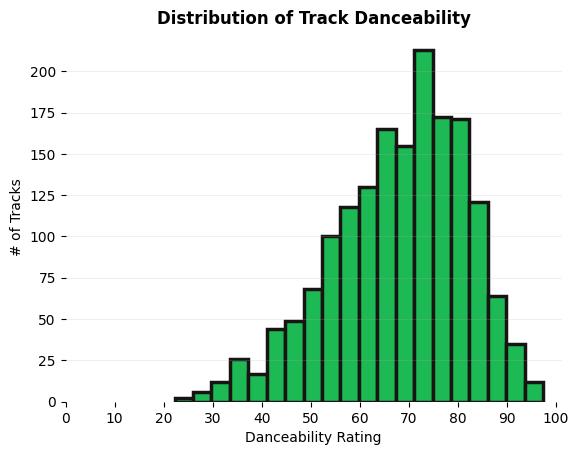

In [62]:
plt.grid(axis="y", alpha=0.2)
plt.hist(
    distinct_tracks["danceability"] * 100,
    rwidth=1,
    edgecolor=spotify_black,
    bins=20,
    color=spotify_green,
    linewidth=2.5,
)
plt.xlabel("Danceability Rating")
plt.ylabel("# of Tracks")
# make title bold
plt.title("Distribution of Track Danceability", fontweight="bold")
plt.xticks(range(0, 101, 10))
plt.box(False)
plt.show()